In [2]:
from Utils.ConfigProvider import ConfigProvider
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
config = ConfigProvider.config()
%matplotlib inline
%load_ext autoreload
%autoreload 2

Enter config
Leave config


Let’s look at the data


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'inspected')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'reference')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'diff')

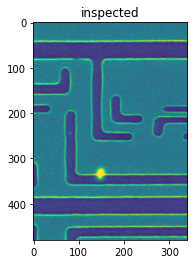

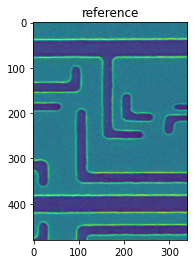

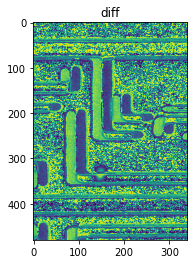

In [3]:
inspected = cv2.imread(config.data.inspected_image_path, 0)
reference = cv2.imread(config.data.reference_image_path, 0)
diff = np.abs(inspected - reference)

plt.figure()
plt.title('inspected')
plt.imshow(inspected)
plt.figure()
plt.title('reference')
plt.imshow(reference)
plt.figure()
plt.title('diff')
plt.imshow(diff)

plt.show()

Looks like noise, and some displacement (like we already knew)

Let’s 1st fight the displacement 1st with simple feature based alignment.
(since the images are pretty close and not rotated, area based registration could be better, but less robust)

Enter config
Leave config


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'matches')

<Figure size 432x288 with 0 Axes>

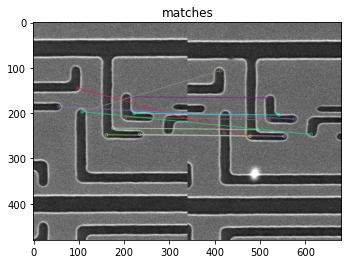

<Figure size 432x288 with 0 Axes>

In [4]:
from alignment.Aligner import Aligner
aligner = Aligner()
matches = aligner.align(reference, inspected)
plt.figure()
plt.title('matches')
plt.imshow(matches)
plt.figure()

